# Data handling

(howto-data-handling-to-gridded)=
## Converting dataset coordinates from flat list to grid

By default measurement control returnds data in a sparse format.
The resulting dataset has a single dimension, and all settables and gettables share it, for example:

In [1]:
from pathlib import Path

import numpy as np
from qcodes import ManualParameter, Parameter, validators

from quantify.data.handling import set_datadir, to_gridded_dataset
from quantify.measurement import MeasurementControl

set_datadir(Path.home() / "quantify-data")

time_a = ManualParameter(
    name="time_a",
    label="Time A",
    unit="s",
    vals=validators.Numbers(),
    initial_value=1,
)
time_b = ManualParameter(
    name="time_b",
    label="Time B",
    unit="s",
    vals=validators.Numbers(),
    initial_value=1,
)
signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)

meas_ctrl = MeasurementControl("meas_ctrl")
meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables(signal)
meas_ctrl.setpoints_grid([np.linspace(0, 5, 10), np.linspace(5, 0, 12)])
dset = meas_ctrl.run("2D-single-float-valued-settable-gettable")
dset

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset> Size: 3kB
Dimensions:  (dim_0: 120)
Coordinates:
    x0       (dim_0) float64 960B 0.0 0.5556 1.111 1.667 ... 3.889 4.444 5.0
    x1       (dim_0) float64 960B 5.0 5.0 5.0 5.0 5.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 960B 75.21 75.95 77.24 79.5 ... 49.36 85.65 148.9
Attributes:
    tuid:                             20250404-150116-573-f0ba51
    name:                             2D-single-float-valued-settable-gettable
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

This format is very close to {class}`COO sparse matrix <scipy.sparse.coo_matrix>`, except that coordinates are not integer.

If the initial data is gridded, it is more convenient to resotre this structure in the dataset for processing.
There is a utility function {func}`quantify.data.handling.to_gridded_dataset` for that:

In [2]:
dset_grid = to_gridded_dataset(dset)
dset_grid

<xarray.Dataset> Size: 1kB
Dimensions:  (x0: 10, x1: 12)
Coordinates:
  * x0       (x0) float64 80B 0.0 0.5556 1.111 1.667 ... 3.333 3.889 4.444 5.0
  * x1       (x1) float64 96B 0.0 0.4545 0.9091 1.364 ... 3.636 4.091 4.545 5.0
Data variables:
    y0       (x0, x1) float64 960B 1.5 1.788 2.241 2.955 ... 178.3 195.5 222.6
Attributes:
    tuid:                             20250404-150116-573-f0ba51
    name:                             2D-single-float-valued-settable-gettable
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

We see that now dataset has two dimensions (`x0` and `x1`), that represent the initial grid for settables `time_a` and `time_b`.
Frecuently this simplifies data processing and analysis a lot, for example, we can display the data straight away:

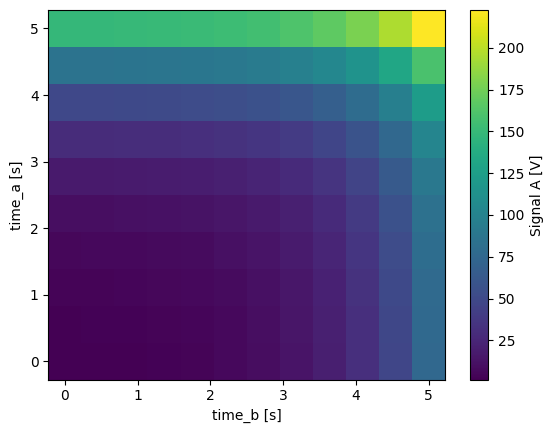

In [3]:
dset_grid.y0.plot(cmap="viridis")